In [3]:
# ==============================================================================
#  ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # Î°úÏª¨ÏóêÏÑúÎäî tqdm.notebook ÎåÄÏã† ÏùºÎ∞ò tqdm ÏÇ¨Ïö©
from tqdm.contrib.concurrent import thread_map
import joblib

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import pairwise_distances, silhouette_score, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample


# joblib (Î≥ëÎ†¨ Ï≤òÎ¶¨Î•º ÏúÑÌï¥)
from joblib import Parallel, delayed

# faiss (KNN Í∞ÄÏÜçÌôîÎ•º ÏúÑÌï¥)
import faiss

# Îç∞Ïù¥ÌÑ∞ Í¥ÄÎ†® 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble
from Ensemble import EnsembleFaissKNN

#DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"

print("‚úî Î™®Îì† ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å!")

‚úî Î™®Îì† ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å!


In [4]:
# ==============================================================================
#  Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
# ==============================================================================

# Ïù¥ÎØ∏ÏßÄ Î°úÎìú Ìï®Ïàò
def load_images_from_folder(base_path):
    images = []
    labels = []
    image_folder_path = os.path.join(base_path, 'images')
    
    if not os.path.exists(image_folder_path):
        raise FileNotFoundError(f"Ïù¥ÎØ∏ÏßÄ Ìè¥ÎçîÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {image_folder_path}\n"
                                f"DATASET_BASE_PATHÎ•º Ïò¨Î∞îÎ•¥Í≤å ÏÑ§Ï†ïÌñàÎäîÏßÄ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")

    for label_name in tqdm(os.listdir(image_folder_path), desc="Ìè¥Îçî Î°úÎìú Ï§ë"):
        label_path = os.path.join(image_folder_path, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_name)
                    else:
                        print(f"Í≤ΩÍ≥†: {img_path} Ïù¥ÎØ∏ÏßÄÎ•º Î°úÎìúÌï† Ïàò ÏóÜÏäµÎãàÎã§.")
                except Exception as e:
                    print(f"Í≤ΩÍ≥†: {img_path} Î°úÎî© Ï§ë Ïò§Î•ò Î∞úÏÉù - {e}")
    return pd.DataFrame({'image_data': images, 'label': labels})

def visualize_features(X_feats, y_labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X_feats)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f'Feature Distribution via {method.upper()}')
    plt.colorbar(scatter, ticks=range(len(set(y_labels))))
    plt.tight_layout()
    plt.show()

In [5]:
def edge(img_bgr):
    # 1) Í∞ïÏ†ú Î¶¨ÏÇ¨Ïù¥Ï¶à
    img_bgr = cv2.resize(img_bgr, (120, 120), interpolation=cv2.INTER_AREA)

    # 2) CLAHE ‚Üí Gray ‚Üí Blur ‚Üí Denoise ‚Üí Canny
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8,8))
    l = clahe.apply(l)
    img_eq = cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

    gray = cv2.cvtColor(img_eq, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    denoised = cv2.fastNlMeansDenoising(blurred, h=10, templateWindowSize=7, searchWindowSize=21)
    edges = cv2.Canny(denoised, 100, 230)

    #plt.imshow(edges, cmap='gray')
    #plt.title("Preprocessed")
    #plt.axis('off')
    #plt.show()
    return edges  # Ìï≠ÏÉÅ (IMG_SIZE, IMG_SIZE)

# 1) Í≥µÌÜµ: BGR ‚Üí LAB ‚Üí CLAHE(L) ‚Üí BGR (ÌïÑÏöî Ïãú)
def apply_clahe(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.createCLAHE(2.0, (8,8)).apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

# 3) Unsharp mask (SIFT Ï†ÑÏö©)
def unsharp(img_gray):
    blurred = cv2.GaussianBlur(img_gray, (3,3), 0)
    return cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# 4) Mild Gaussian blur (LBP/GLCM/Laws)
def mild_blur(img_gray):
    return cv2.GaussianBlur(img_gray, (3,3), 0)

In [6]:
def gray(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

In [7]:
def checkcol(img_bgr):
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    #image=cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8,8,8), [0,180, 0,256, 0,256])
    hist = cv2.normalize(hist, hist).flatten()
    h, s, v = cv2.split(hsv)
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hist_rgb = cv2.calcHist([rgb], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_rgb = cv2.normalize(hist_rgb, hist_rgb).flatten()
    hist_bgr = cv2.calcHist([img_bgr], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_bgr = cv2.normalize(hist_bgr, hist_bgr).flatten()
    #plt.imshow(v)
    #plt.title("Color")
    #plt.axis('off')
    #plt.show()
     # ‚úÖ 2D ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(10, 4))
    plt.plot(hist, color='blue')
    plt.title("Flattened HSV Histogram")
    plt.xlabel("Bin Index")
    plt.ylabel("Normalized Value")
    plt.tight_layout()
    plt.show()
    return hsv


In [8]:
tst = "C:/Users/bvb09/.cache/kagglehub/datasets/pre"
timg = load_images_from_folder(tst)
timg['processed_image_data'] = [edge(img) for img in tqdm(timg['image_data'], desc="Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨")]

Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [00:00<00:00, 26.36it/s]


In [9]:
# ==============================================================================
#  ÌîºÏ≥ê Ï∂îÏ∂ú Ìï®Ïàò
# ==================================================================:============

def extract_color_histogram_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, (8,8,8), [0,180,0,256,0,256])
    return cv2.normalize(hist, hist).flatten()

def extract_sift_pca_mean(img_bgr, pca_model=None, n_components=32):
    # 1. BGR ‚Üí GRAY
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # 2. SIFT ÏÉùÏÑ± Î∞è ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ Ï∂îÏ∂ú
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    if descriptors is None or len(descriptors) == 0:
        # ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ ÏóÜÏùÑ Í≤ΩÏö∞ 0 Î≤°ÌÑ∞ Î∞òÌôò
        return np.zeros(n_components if pca_model else 128, dtype=np.float32)

    # 3. PCA Ï≤òÎ¶¨
    if pca_model is None:
        # PCA ÌïôÏäµÎèÑ Ìè¨Ìï® (Î≥¥ÌÜµ ÌïôÏäµÏÖãÏóêÏÑú Îî∞Î°ú ÌïôÏäµÌïòÎäî Í≤å Ï¢ãÏùå)
        pca_model = PCA(n_components=n_components)
        descriptors_pca = pca_model.fit_transform(descriptors)
    else:
        descriptors_pca = pca_model.transform(descriptors)

    # 4. ÌèâÍ∑† Î≤°ÌÑ∞ Î∞òÌôò
    mean_vector = np.mean(descriptors_pca, axis=0)
    return mean_vector.astype(np.float32)

def extract_glcm_features(image):
    if image is None:
        num_props = 6
        num_distances = 3 # ÏïÑÎûò distances Î¶¨Ïä§Ìä∏ Í∏∏Ïù¥
        num_angles = 4    # ÏïÑÎûò angles Î¶¨Ïä§Ìä∏ Í∏∏Ïù¥
        return np.zeros(num_props * num_distances * num_angles)
    
    img_glcm = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_glcm = mild_blur(img_glcm)
    img_glcm = apply_clahe(cv2.cvtColor(img_glcm, cv2.COLOR_GRAY2BGR))
    gray_image = cv2.cvtColor(img_glcm, cv2.COLOR_BGR2GRAY)

    distances = [1, 2, 3] # ÏòàÏãú Í±∞Î¶¨ Í∞í
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # ÏòàÏãú Í∞ÅÎèÑ Í∞í
    
    try:
        glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
        
        props_to_extract = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        glcm_features = []
        for prop in props_to_extract:
            glcm_features.append(graycoprops(glcm, prop).ravel())
            
        return np.concatenate(glcm_features)
    except Exception as e:
        # Ïò§Î•ò Î∞úÏÉù Ïãú Ï≤òÎ¶¨ (Ïòà: 0ÏúºÎ°ú Ï±ÑÏõåÏßÑ Î∞∞Ïó¥ Î∞òÌôò)
        print(f"GLCM Ï∂îÏ∂ú Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        num_props = 6
        num_distances = len(distances) 
        num_angles = len(angles)    
        return np.zeros(num_props * num_distances * num_angles)

def extract_hog_features(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
     # 1) Î¶¨ÏÇ¨Ïù¥Ï¶à
    img = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA)
    # 2) Í∑∏Î†àÏù¥Ïä§ÏºÄÏùº Î≥ÄÌôò
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    features = hog(gray,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True,
                   feature_vector=True)
    return features.astype(np.float32)

def extract_sift_descriptors_from_array(image):
    img = apply_clahe(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image=unsharp(img)

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_image, None) # ÌÇ§Ìè¨Ïù∏Ìä∏ÏôÄ ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ Í≥ÑÏÇ∞

    return des # ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÏóÜÏùÑ Í≤ΩÏö∞ None Î∞òÌôò

def extract_lbp_features_from_array(image, P=8, R=1, method='uniform'):
    
    image=apply_clahe(image)
    #image=mild_blur(image)
    gray_image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # local_binary_pattern Ìï®ÏàòÎäî float ÌÉÄÏûÖ Ïù¥ÎØ∏ÏßÄÎ•º ÏÑ†Ìò∏ÌïòÏßÄÎßå, skimageÎäî UBYTEÎèÑ Ï≤òÎ¶¨
    lbp_image = local_binary_pattern(gray_image, P, R, method=method)

    # LBP ÌûàÏä§ÌÜ†Í∑∏Îû® Í≥ÑÏÇ∞
    max_bins = P * (P - 1) + 3 if method == 'default' else P + 2 # uniformÏùò Í≤ΩÏö∞ P+2
    hist, _ = np.histogram(lbp_image.ravel(), bins=max_bins, range=(0, max_bins), density=True)
    return hist

# Laws' Texture Energy - Í∏∞Ï°¥Í≥º ÎèôÏùº
def extract_laws_energy_features(image, window_size=15):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray=mild_blur(image_gray)

    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)

def learn_bovw_vocabulary(all_sift_descriptors, num_clusters=200):
    """
    Bag of Visual Words (BoVW)Î•º ÏúÑÌïú ÏãúÍ∞ÅÏ†Å Îã®Ïñ¥(Vocabulary)Î•º ÌïôÏäµÌï©ÎãàÎã§.
    """
    concatenated_descriptors = np.vstack([des for des in all_sift_descriptors if des is not None])
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(concatenated_descriptors.astype(np.float32),
                                              num_clusters, None, criteria, 10, flags)
    return centers

def create_bovw_histogram(sift_descriptors, vocabulary):
    """
    SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ÏôÄ ÌïôÏäµÎêú VocabularyÎ•º ÏÇ¨Ïö©ÌïòÏó¨ BoVW ÌûàÏä§ÌÜ†Í∑∏Îû®ÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
    """
    num_clusters = vocabulary.shape[0]
    histogram = np.zeros(num_clusters, dtype=np.float32)

    if sift_descriptors is not None and len(sift_descriptors) > 0:
        for des in sift_descriptors:
            distances = np.linalg.norm(vocabulary - des, axis=1)
            closest_cluster_idx = np.argmin(distances)
            histogram[closest_cluster_idx] += 1
        histogram = cv2.normalize(histogram, histogram, norm_type=cv2.NORM_L2).flatten()
    return histogram

print("‚úî ÌäπÏßï Ï∂îÏ∂ú Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å")

‚úî ÌäπÏßï Ï∂îÏ∂ú Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å


In [10]:
def get_features_for_split(df, image_dir, bovw_vocabulary=None, num_bovw_clusters=200):

    hog_feats = []
    color_feats = []
    lbp_feats = []
    sift_descriptors_raw = [] # SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Îßå

    dataset_name = df.name if hasattr(df, 'name') else 'dataset'
    print(f"Loading images and extracting raw features for {dataset_name}...")

    # Ïù¥ÎØ∏ÏßÄÎ•º Ìïú Î≤à Î°úÎìúÌïòÍ≥†, Ïù¥Î•º Í∞Å ÌäπÏßï Ï∂îÏ∂ú Ìï®ÏàòÏóê Ï†ÑÎã¨
    for img_name in tqdm(df['image_name'], desc=f"Processing images for {dataset_name}"):
        img_path = os.path.join(image_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")

        # Î™®Îì† Ïù¥ÎØ∏ÏßÄÍ∞Ä Ïù¥ÎØ∏ 120x120ÏúºÎ°ú Î¶¨ÏÇ¨Ïù¥Ï¶àÎêòÏóàÎã§Í≥† Í∞ÄÏ†ïÌïòÎØÄÎ°ú, Ï∂îÍ∞Ä Î¶¨ÏÇ¨Ïù¥Ï¶à ÏóÜÏùå
        # Îã§Îßå, cv2.imreadÎäî BGRÎ°ú ÏùΩÏúºÎØÄÎ°ú, Ïª¨Îü¨ ÌûàÏä§ÌÜ†Í∑∏Îû®ÏùÑ ÏúÑÌï¥ RGB Î≥ÄÌôòÏùÄ ÌïÑÏöî
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB Î≥ÄÌôòÏùÄ Ïó¨Í∏∞ÏÑú Ìïú Î≤àÎßå ÏàòÌñâ

        # Í∞Å ÌäπÏßï Ï∂îÏ∂ú Ìï®ÏàòÏóê Ïù¥ÎØ∏ÏßÄ Î∞∞Ïó¥ Ï†ÑÎã¨
        hog_feats.append(extract_hog_features(image_rgb)) # HOGÎäî ÎÇ¥Î∂ÄÏóêÏÑú GRAY Î≥ÄÌôò
        color_feats.append(extract_color_histogram_features(image_rgb))
        lbp_feats.append(extract_lbp_features_from_array(image_rgb)) # LBPÎäî ÎÇ¥Î∂ÄÏóêÏÑú GRAY Î≥ÄÌôò
        sift_descriptors_raw.append(extract_sift_descriptors_from_array(image_rgb)) # SIFTÎäî ÎÇ¥Î∂ÄÏóêÏÑú GRAY Î≥ÄÌôò


    current_bovw_vocab = bovw_vocabulary
    if current_bovw_vocab is None: # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÎßå Vocabulary ÌïôÏäµ
        print(f"Learning BoVW vocabulary for {dataset_name}...")
        current_bovw_vocab = learn_bovw_vocabulary(sift_descriptors_raw, num_clusters=num_bovw_clusters)
        print(f"BoVW vocabulary learned with {current_bovw_vocab.shape[0]} clusters.")

    all_bovw_feats = []
    print(f"Creating BoVW histograms for {dataset_name}...")
    for sift_des in tqdm(sift_descriptors_raw):
        all_bovw_feats.append(create_bovw_histogram(sift_des, current_bovw_vocab))

    return (np.array(hog_feats), np.array(color_feats),
            np.array(all_bovw_feats), np.array(lbp_feats), current_bovw_vocab)


def combine_features(*feature_arrays):
    reshaped = []
    for arr in feature_arrays:
        arr = np.asarray(arr)
        if arr.ndim == 3:
            # (N, H, W) ‚Üí (N, H*W)
            arr = arr.reshape(arr.shape[0], -1)
        elif arr.ndim == 1:
            # (D,) ‚Üí (1, D)
            arr = arr.reshape(1, -1)
        reshaped.append(arr)
    return np.hstack(reshaped)


In [11]:
# ==============================================================================
#  Î∂ÑÎ•ò Î™®Îç∏ Î∞è ÌïôÏäµ/ÌèâÍ∞Ä Ìï®Ïàò
# ==============================================================================
# Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞ò Faiss KNN ÌïôÏäµ (ÏàòÏ†ïÎê®)
def train_faiss_knn_euclidean(X_train, y_train, n_neighbors=3):
    # Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞òÏóêÏÑúÎäî Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôîÍ∞Ä ÌïÑÏöî ÏóÜÏäµÎãàÎã§.
    # X_train = normalize(X_train, axis=1) # Ïù¥ Ï§ÑÏùÑ Ï£ºÏÑù Ï≤òÎ¶¨ÌïòÍ±∞ÎÇò ÏÇ≠Ï†úÌï©ÎãàÎã§.
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]

    # Inner Product (IP) ÎåÄÏã† L2 Í±∞Î¶¨Î•º ÏÇ¨Ïö©ÌïòÎäî Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    index = faiss.IndexFlatL2(D) # <-- Î≥ÄÍ≤ΩÎêú Î∂ÄÎ∂Ñ
    index.add(X_train)

    return index, y_train, n_neighbors

# Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞ò Faiss KNN ÏòàÏ∏° (ÏàòÏ†ïÎê®)
def predict_faiss_knn_euclidean(index, y_train_labels, n_neighbors, X_test):
    # Ïú†ÌÅ¥Î¶¨Îìú Í±∞Î¶¨ Í∏∞Î∞òÏóêÏÑúÎäî ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôîÎèÑ ÌïÑÏöî ÏóÜÏäµÎãàÎã§.
    # X_test = normalize(X_test, axis=1) # Ïù¥ Ï§ÑÏùÑ Ï£ºÏÑù Ï≤òÎ¶¨ÌïòÍ±∞ÎÇò ÏÇ≠Ï†úÌï©ÎãàÎã§.
    X_test = X_test.astype(np.float32)

    # search Í≤∞Í≥ºÎäî D (Í±∞Î¶¨)ÏôÄ I (Ïù∏Îç±Ïä§)ÏûÖÎãàÎã§.
    # L2 Í±∞Î¶¨Ïù¥ÎØÄÎ°ú Í±∞Î¶¨Í∞Ä ÏûëÏùÑÏàòÎ°ù Í∞ÄÍπåÏö¥ Í≤ÉÏûÖÎãàÎã§.
    distances, indices = index.search(X_test, n_neighbors) # <-- Ïù¥Î¶Ñ Î≥ÄÍ≤Ω (similarities -> distances)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        # Í±∞Î¶¨ Í∏∞Î∞òÏù¥ÎØÄÎ°ú Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ïù¥ÏõÉÎì§Ïùò Î†àÏù¥Î∏îÏùÑ ÌÜµÌï¥ Îã§ÏàòÍ≤∞ Ìà¨Ìëú
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

# test() Ìï®Ïàò
def test(model_tuple, X_test, y_test, average='weighted'):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k={n_neighbors})...")
    y_pred = predict_faiss_knn_euclidean(faiss_index, y_train_labels, n_neighbors, X_test)
    print("  ‚úî ÏòàÏ∏° ÏôÑÎ£å.")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)
    print(f"[Test Accuracy] {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return y_pred
print("‚úî Î∂ÑÎ•ò Î™®Îç∏ Î∞è ÌïôÏäµ/ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å (Faiss Ï†ÅÏö©).")

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


‚úî Î∂ÑÎ•ò Î™®Îç∏ Î∞è ÌïôÏäµ/ÌèâÍ∞Ä Ìï®Ïàò Ï†ïÏùò ÏôÑÎ£å (Faiss Ï†ÅÏö©).


In [12]:
DATASET_BASE_PATH = "C:/Users/bvb09/recaptcha-dataset" 

try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"‚úî Ï¥ù {len(images_df)}Í∞úÏùò Ïù¥ÎØ∏ÏßÄ Î°úÎìú ÏôÑÎ£å.")
except FileNotFoundError as e:
    print(f"Ïò§Î•ò: {e}")
    

# 2. ÎùºÎ≤® Ïù∏ÏΩîÎî©
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"‚úî ÎùºÎ≤® Ïù∏ÏΩîÎî© ÏôÑÎ£å. ÌÅ¥ÎûòÏä§: {le.classes_}")

images_df = images_df.groupby('label_encoded').apply(
    lambda g: g.sample(n=min(100, len(g)), random_state=42)
).reset_index(drop=True)


# Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Ï†ÑÏ≤òÎ¶¨ ÏàòÌñâ
#print("‚è≥ Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Ï§ë...")
#images_df['processed_image_data'] = [preprocess_image(img) for img in tqdm(images_df['image_data'], desc="Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨")]
#print("‚úî Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å.")


Ìè¥Îçî Î°úÎìú Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:06<00:00,  1.61it/s]

‚úî Ï¥ù 10292Í∞úÏùò Ïù¥ÎØ∏ÏßÄ Î°úÎìú ÏôÑÎ£å.
‚úî ÎùºÎ≤® Ïù∏ÏΩîÎî© ÏôÑÎ£å. ÌÅ¥ÎûòÏä§: ['Bicycle' 'Bridge' 'Bus' 'Car' 'Chimney' 'Crosswalk' 'Hydrant'
 'Motorcycle' 'Palm' 'Traffic Light']



C:\Users\bvb09\AppData\Local\Temp\ipykernel_10260\3370475517.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_df = images_df.groupby('label_encoded').apply(


In [13]:
# Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Í∏∞Î≥∏ ÌäπÏßï ÎØ∏Î¶¨ Ï∂îÏ∂ú
print("‚è≥ Í∏∞Î≥∏ ÌäπÏßï Ï∂îÏ∂ú Ï§ë (Color, HOG, LBP, SIFT descriptors)...")
features_color_all = np.array([extract_color_histogram_features(img) for img in tqdm(images_df['image_data'], desc="Color Histogram Ï∂îÏ∂ú")])

‚è≥ Í∏∞Î≥∏ ÌäπÏßï Ï∂îÏ∂ú Ï§ë (Color, HOG, LBP, SIFT descriptors)...


Color Histogram Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 956/956 [00:00<00:00, 17535.19it/s]


In [14]:
features_lbp_all = np.array([extract_lbp_features_from_array(img) for img in tqdm(images_df['image_data'], desc="LBP Ï∂îÏ∂ú")])


LBP Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 956/956 [00:01<00:00, 576.40it/s]


In [15]:
hog_list = [
    extract_hog_features(img)
    for img in tqdm(images_df['image_data'], desc="HOG Ï∂îÏ∂ú")
]
features_hog_all = np.vstack(hog_list)  # shape = (n_images, hog_dim)
print(features_hog_all.shape)
pca = PCA(n_components=50, random_state=42)
features_hog_all = pca.fit_transform(features_hog_all)


HOG Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 956/956 [00:01<00:00, 752.26it/s]

(956, 1296)


In [16]:
#features_glcm_all = np.array([extract_glcm_features(img) for img in tqdm(images_df['image_data'], desc="GLCM Ï∂îÏ∂ú")])


In [17]:
features_laws_all = np.array([extract_laws_energy_features(img) for img in tqdm(images_df['image_data'], desc="Laws' Texture Ï∂îÏ∂ú")])

Laws' Texture Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 956/956 [00:05<00:00, 181.02it/s]


In [18]:
sift_descriptors_list_all = [extract_sift_descriptors_from_array(img) for img in tqdm(images_df['image_data'], desc="SIFT Descriptors Ï∂îÏ∂ú")]

SIFT Descriptors Ï∂îÏ∂ú: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 956/956 [00:02<00:00, 326.50it/s]



‚ñ∂ Ï¥ù 8Í∞úÏùò ÌäπÏßï Ï°∞Ìï©Ïóê ÎåÄÌï¥ ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÏàòÌñâÌï©ÎãàÎã§.
  - ('color', 'sift')
  - ('color', 'lbp')
  - ('color', 'lbp', 'hog')
  - ('color', 'law', 'hog')
  - ('color', 'law', 'sift')
  - ('color', 'lbp', 'sift', 'hog')
  - ('color', 'law', 'sift', 'hog')
  - ('color', 'lbp', 'sift', 'hog', 'law')

‚úî Stratified K-Fold ÏÑ§Ï†ï ÏôÑÎ£å (5-Fold)

=============== FOLD 1/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 1)

--- Ï°∞Ìï©: color+sift (Fold 1) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 1, Ï°∞Ìï© color+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3229 (Fold 1, Ï°∞Ìï© color+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3343 (Fold 1, Ï°∞Ìï© color+sift)


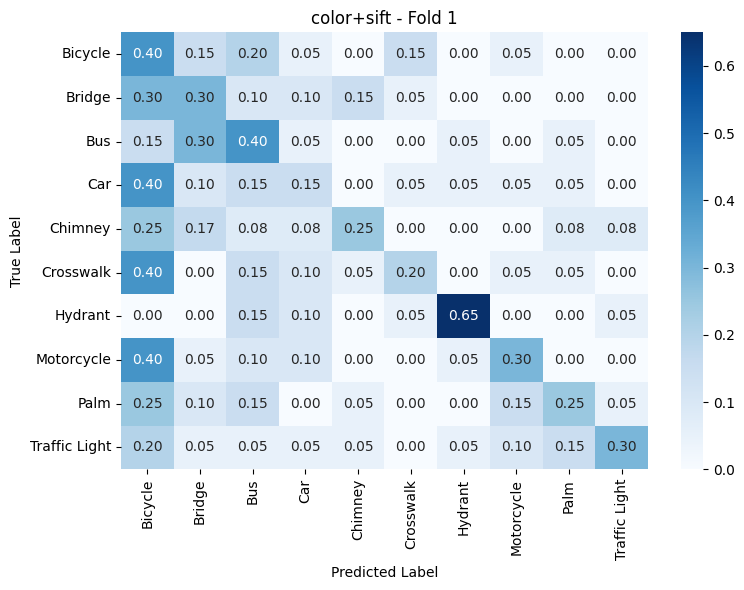


--- Ï°∞Ìï©: color+lbp (Fold 1) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2500 (Fold 1, Ï°∞Ìï© color+lbp)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2575 (Fold 1, Ï°∞Ìï© color+lbp)


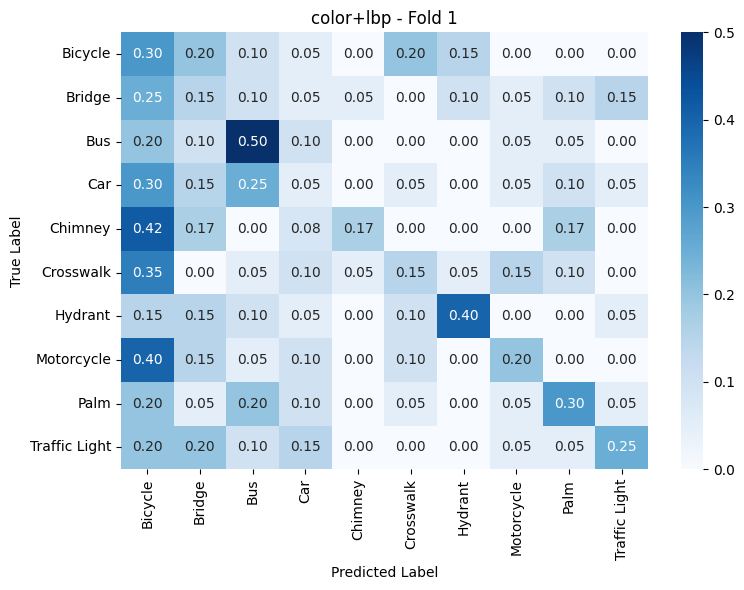


--- Ï°∞Ìï©: color+lbp+hog (Fold 1) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3490 (Fold 1, Ï°∞Ìï© color+lbp+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3430 (Fold 1, Ï°∞Ìï© color+lbp+hog)


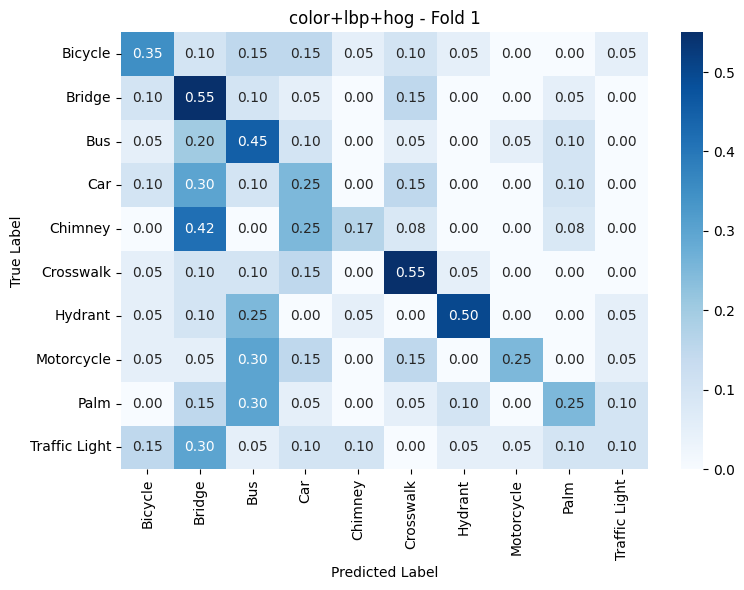


--- Ï°∞Ìï©: color+law+hog (Fold 1) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3490 (Fold 1, Ï°∞Ìï© color+law+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3419 (Fold 1, Ï°∞Ìï© color+law+hog)


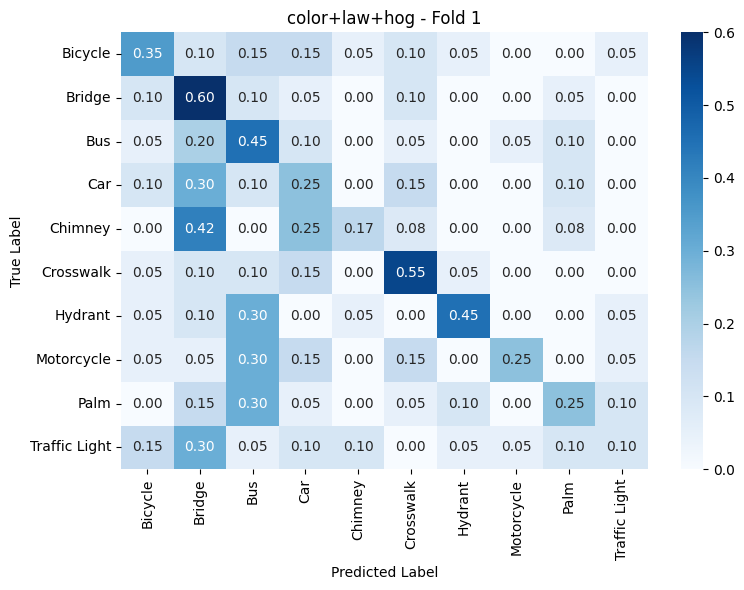


--- Ï°∞Ìï©: color+law+sift (Fold 1) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 1, Ï°∞Ìï© color+law+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+law+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+law+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3229 (Fold 1, Ï°∞Ìï© color+law+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3343 (Fold 1, Ï°∞Ìï© color+law+sift)


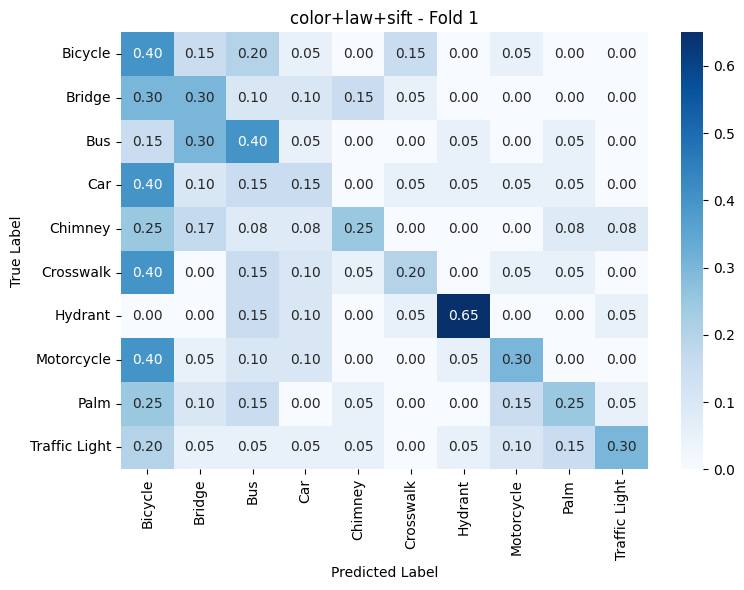


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 1) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 1, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3594 (Fold 1, Ï°∞Ìï© color+lbp+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3520 (Fold 1, Ï°∞Ìï© color+lbp+sift+hog)


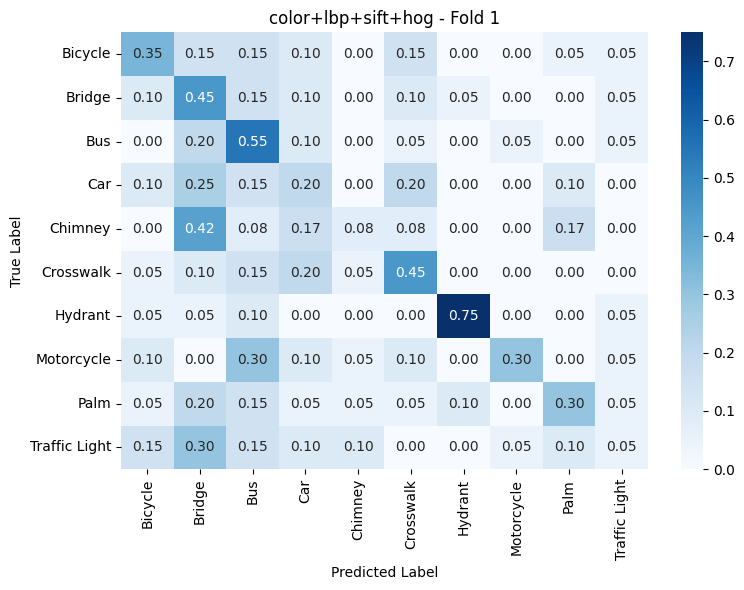


--- Ï°∞Ìï©: color+law+sift+hog (Fold 1) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 1, Ï°∞Ìï© color+law+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+law+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+law+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3542 (Fold 1, Ï°∞Ìï© color+law+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3485 (Fold 1, Ï°∞Ìï© color+law+sift+hog)


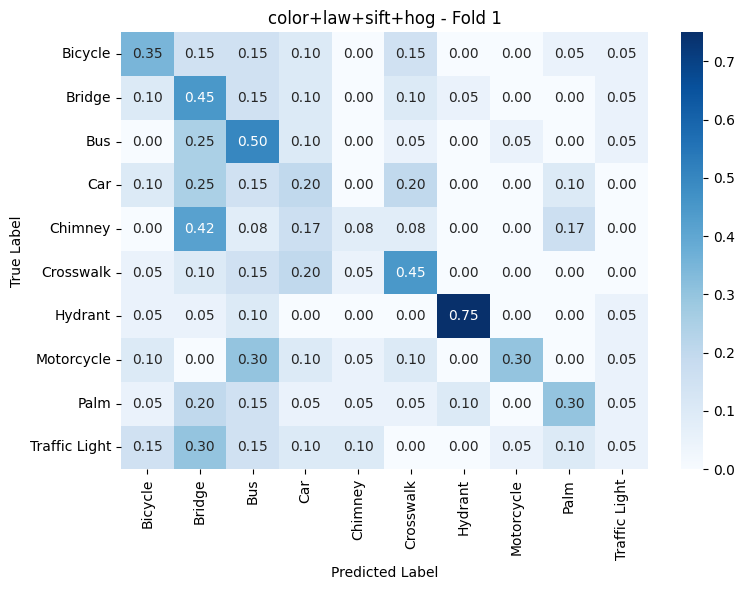


--- Ï°∞Ìï©: color+lbp+sift+hog+law (Fold 1) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 1, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 1, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 1, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3594 (Fold 1, Ï°∞Ìï© color+lbp+sift+hog+law)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3520 (Fold 1, Ï°∞Ìï© color+lbp+sift+hog+law)


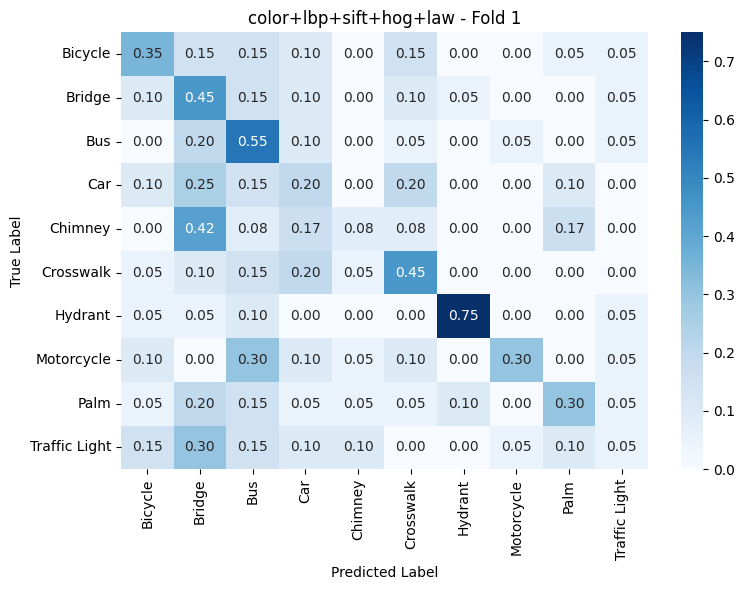


=============== FOLD 2/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 2)

--- Ï°∞Ìï©: color+sift (Fold 2) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 2, Ï°∞Ìï© color+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3246 (Fold 2, Ï°∞Ìï© color+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3110 (Fold 2, Ï°∞Ìï© color+sift)


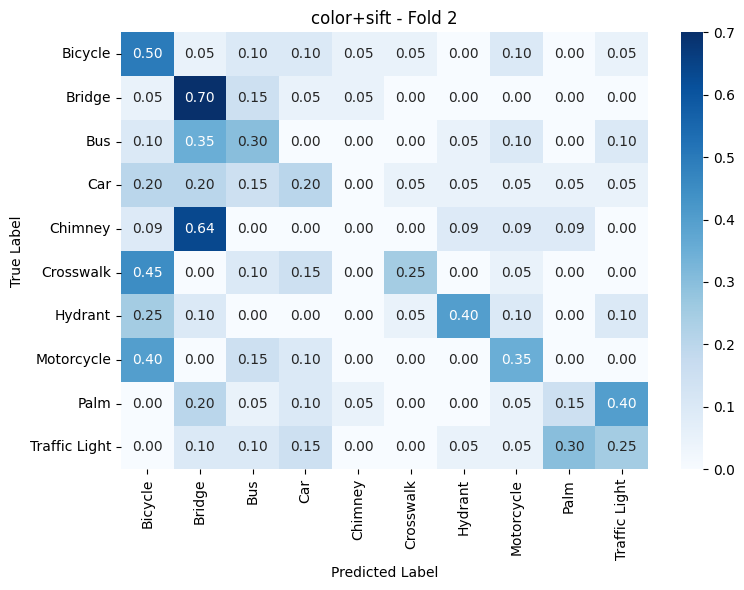


--- Ï°∞Ìï©: color+lbp (Fold 2) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3141 (Fold 2, Ï°∞Ìï© color+lbp)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3106 (Fold 2, Ï°∞Ìï© color+lbp)


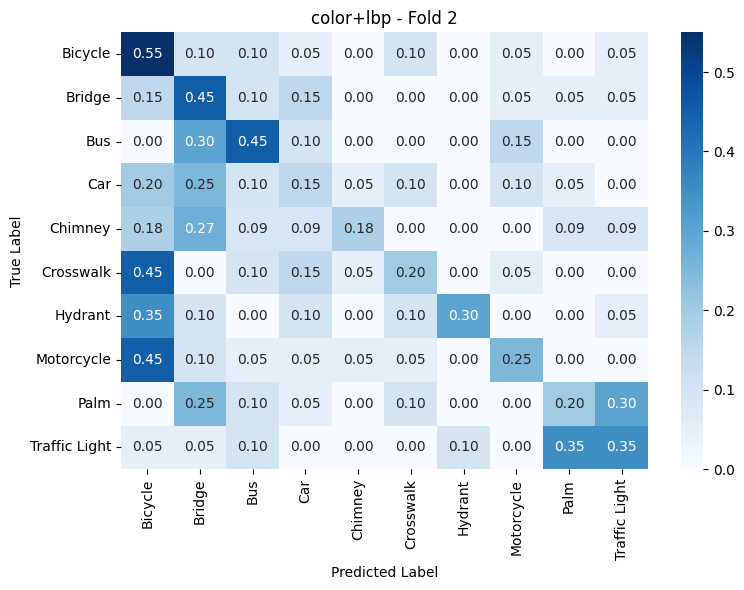


--- Ï°∞Ìï©: color+lbp+hog (Fold 2) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3246 (Fold 2, Ï°∞Ìï© color+lbp+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3127 (Fold 2, Ï°∞Ìï© color+lbp+hog)


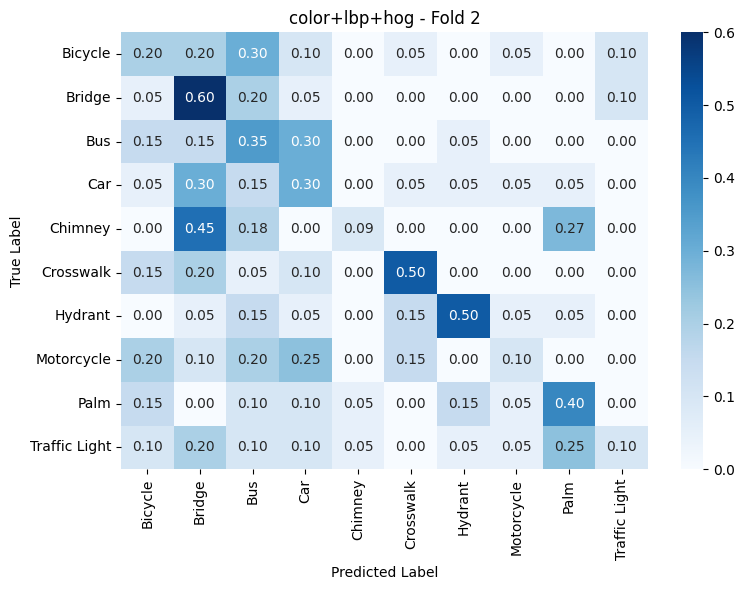


--- Ï°∞Ìï©: color+law+hog (Fold 2) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3246 (Fold 2, Ï°∞Ìï© color+law+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3129 (Fold 2, Ï°∞Ìï© color+law+hog)


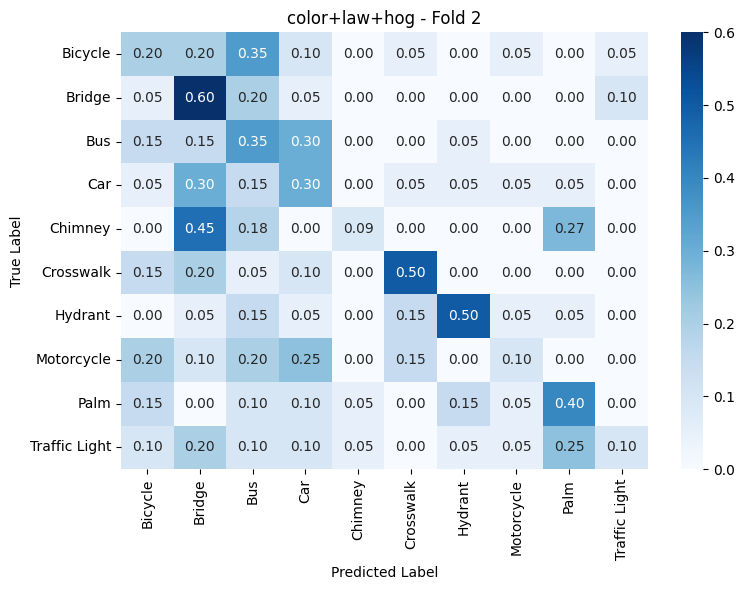


--- Ï°∞Ìï©: color+law+sift (Fold 2) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 2, Ï°∞Ìï© color+law+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+law+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+law+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3246 (Fold 2, Ï°∞Ìï© color+law+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3110 (Fold 2, Ï°∞Ìï© color+law+sift)


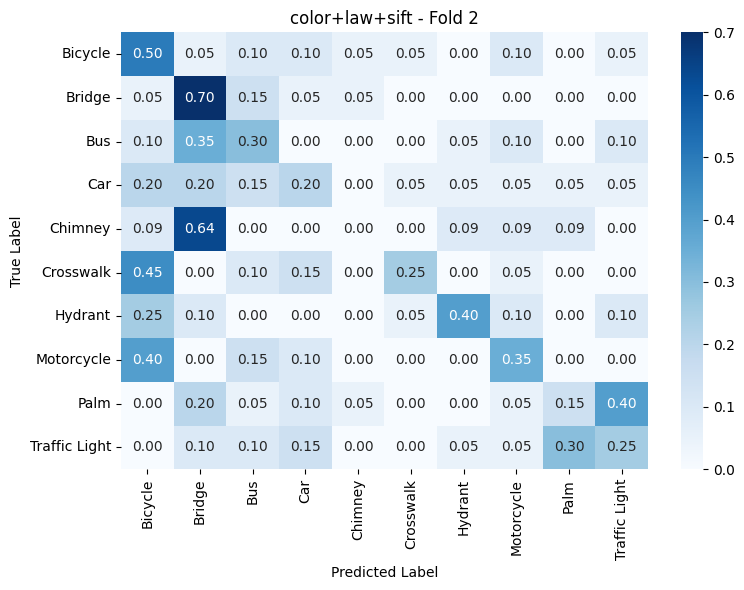


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 2) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 2, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3717 (Fold 2, Ï°∞Ìï© color+lbp+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3660 (Fold 2, Ï°∞Ìï© color+lbp+sift+hog)


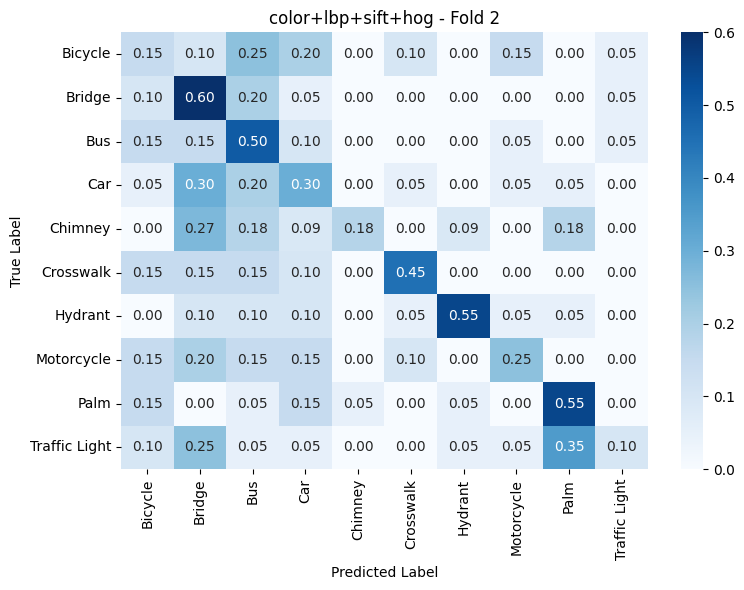


--- Ï°∞Ìï©: color+law+sift+hog (Fold 2) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 2, Ï°∞Ìï© color+law+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+law+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+law+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3717 (Fold 2, Ï°∞Ìï© color+law+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3647 (Fold 2, Ï°∞Ìï© color+law+sift+hog)


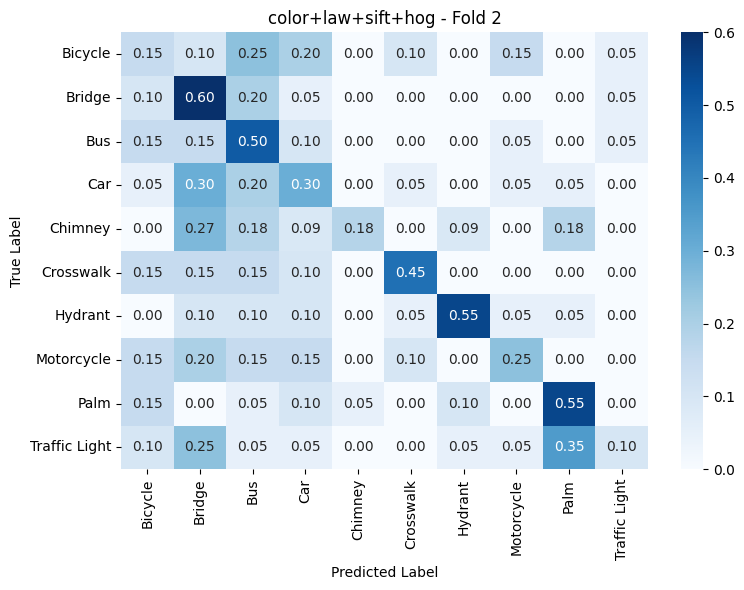


--- Ï°∞Ìï©: color+lbp+sift+hog+law (Fold 2) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 2, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 2, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 2, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3717 (Fold 2, Ï°∞Ìï© color+lbp+sift+hog+law)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3660 (Fold 2, Ï°∞Ìï© color+lbp+sift+hog+law)


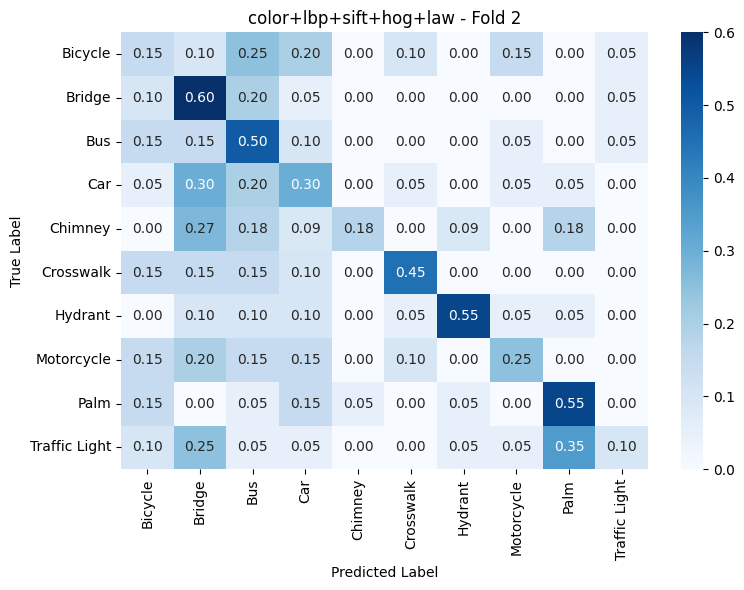


=============== FOLD 3/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 3)

--- Ï°∞Ìï©: color+sift (Fold 3) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 3, Ï°∞Ìï© color+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2880 (Fold 3, Ï°∞Ìï© color+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2994 (Fold 3, Ï°∞Ìï© color+sift)


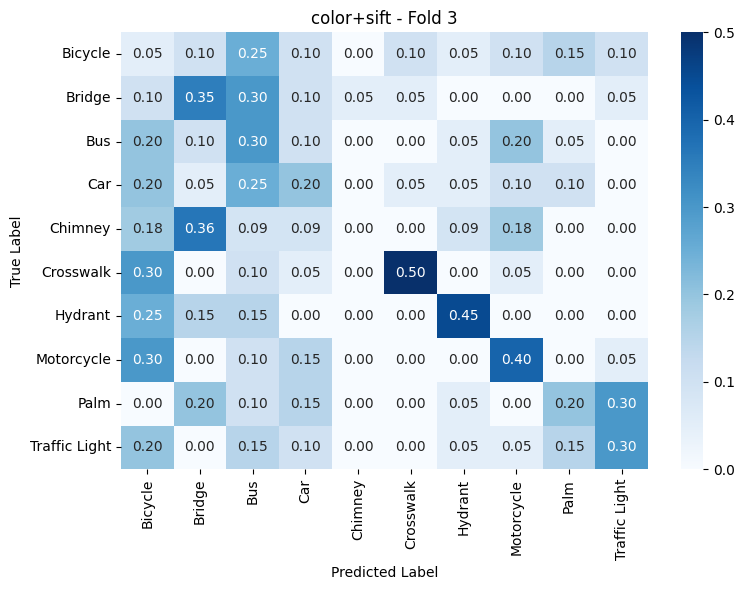


--- Ï°∞Ìï©: color+lbp (Fold 3) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2513 (Fold 3, Ï°∞Ìï© color+lbp)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2536 (Fold 3, Ï°∞Ìï© color+lbp)


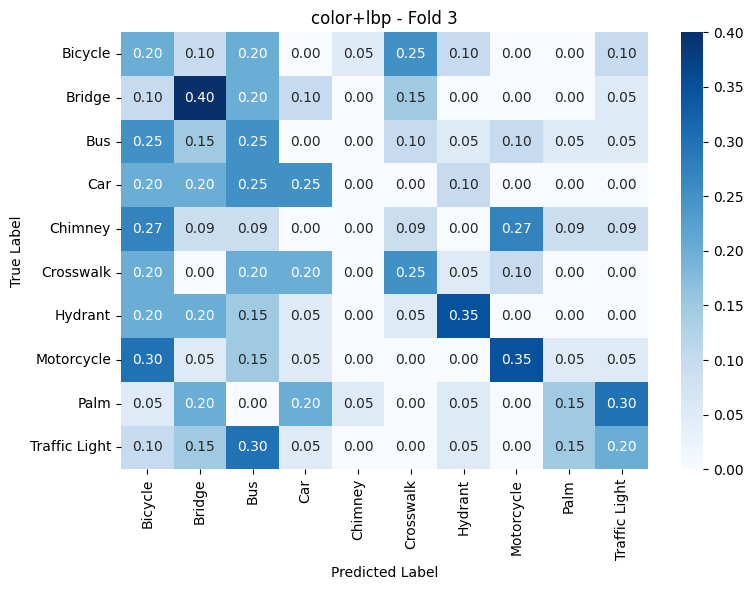


--- Ï°∞Ìï©: color+lbp+hog (Fold 3) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2827 (Fold 3, Ï°∞Ìï© color+lbp+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2692 (Fold 3, Ï°∞Ìï© color+lbp+hog)


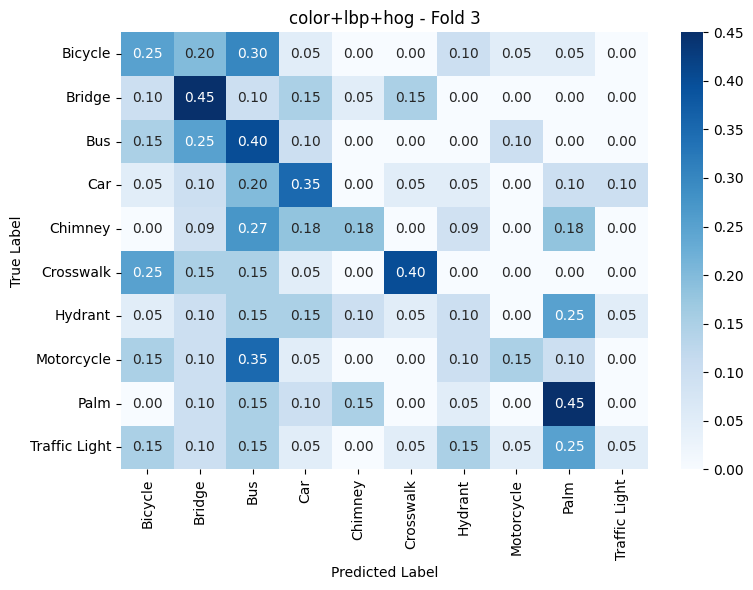


--- Ï°∞Ìï©: color+law+hog (Fold 3) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2775 (Fold 3, Ï°∞Ìï© color+law+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2648 (Fold 3, Ï°∞Ìï© color+law+hog)


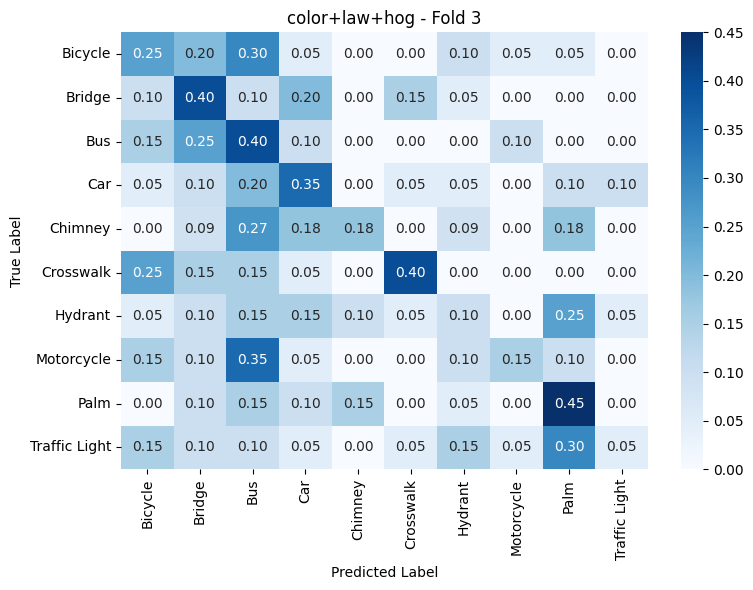


--- Ï°∞Ìï©: color+law+sift (Fold 3) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 3, Ï°∞Ìï© color+law+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+law+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+law+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2880 (Fold 3, Ï°∞Ìï© color+law+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2994 (Fold 3, Ï°∞Ìï© color+law+sift)


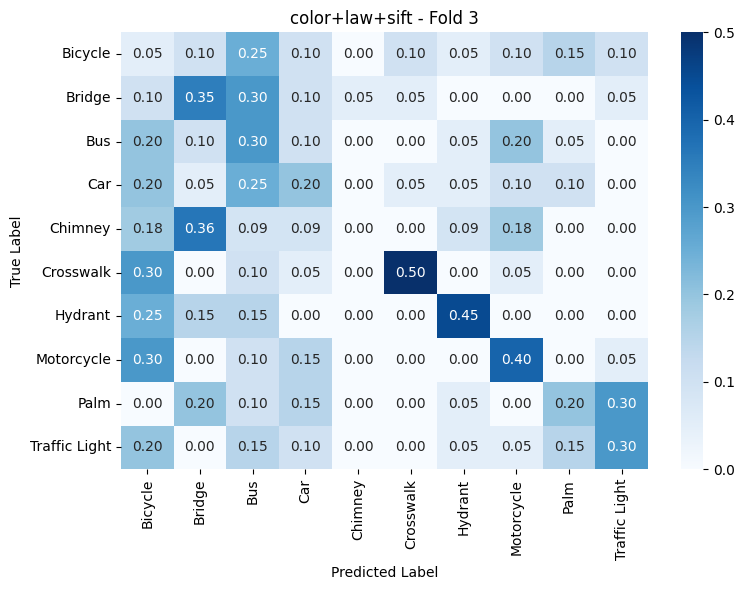


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 3) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 3, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3298 (Fold 3, Ï°∞Ìï© color+lbp+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3264 (Fold 3, Ï°∞Ìï© color+lbp+sift+hog)


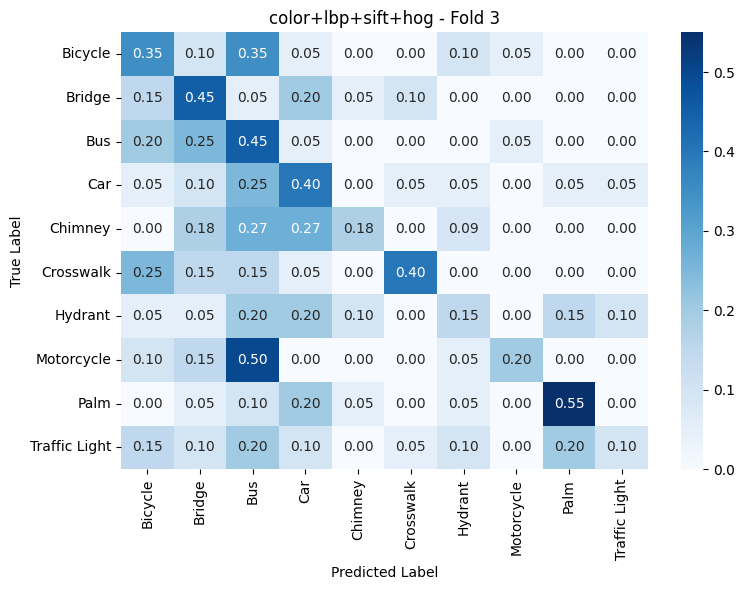


--- Ï°∞Ìï©: color+law+sift+hog (Fold 3) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 3, Ï°∞Ìï© color+law+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+law+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+law+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3298 (Fold 3, Ï°∞Ìï© color+law+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3261 (Fold 3, Ï°∞Ìï© color+law+sift+hog)


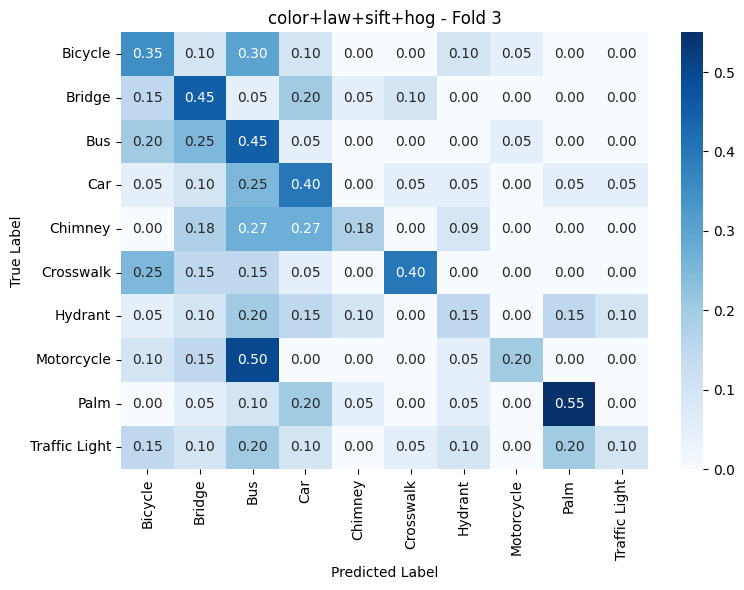


--- Ï°∞Ìï©: color+lbp+sift+hog+law (Fold 3) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 3, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 3, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 3, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3298 (Fold 3, Ï°∞Ìï© color+lbp+sift+hog+law)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3264 (Fold 3, Ï°∞Ìï© color+lbp+sift+hog+law)


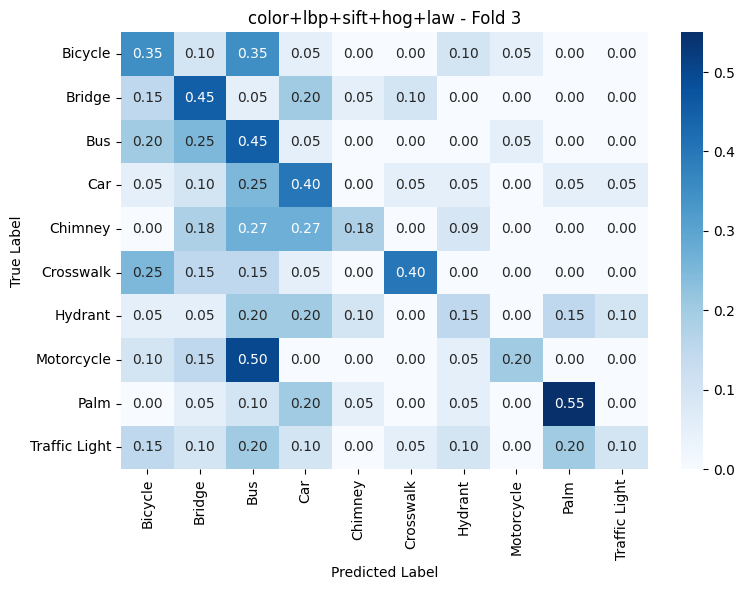


=============== FOLD 4/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 4)

--- Ï°∞Ìï©: color+sift (Fold 4) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 4, Ï°∞Ìï© color+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2880 (Fold 4, Ï°∞Ìï© color+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2882 (Fold 4, Ï°∞Ìï© color+sift)


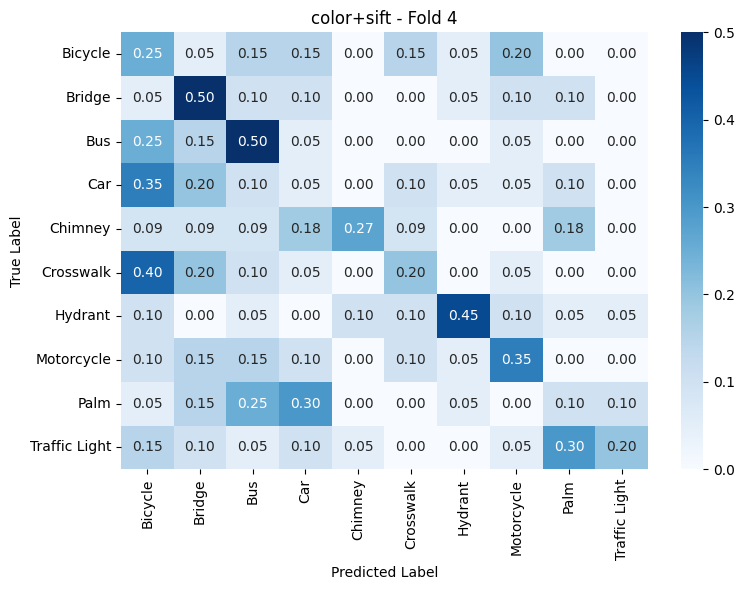


--- Ï°∞Ìï©: color+lbp (Fold 4) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+lbp)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+lbp)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2042 (Fold 4, Ï°∞Ìï© color+lbp)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2036 (Fold 4, Ï°∞Ìï© color+lbp)


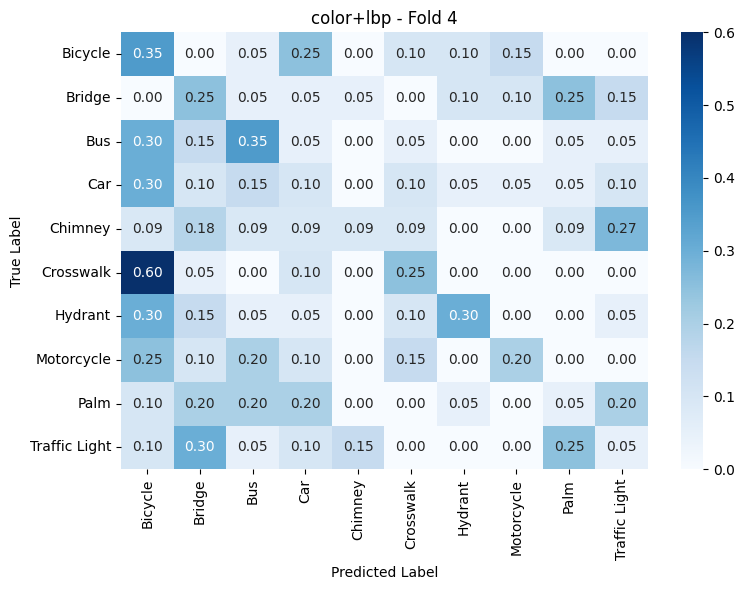


--- Ï°∞Ìï©: color+lbp+hog (Fold 4) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+lbp+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+lbp+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3141 (Fold 4, Ï°∞Ìï© color+lbp+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3016 (Fold 4, Ï°∞Ìï© color+lbp+hog)


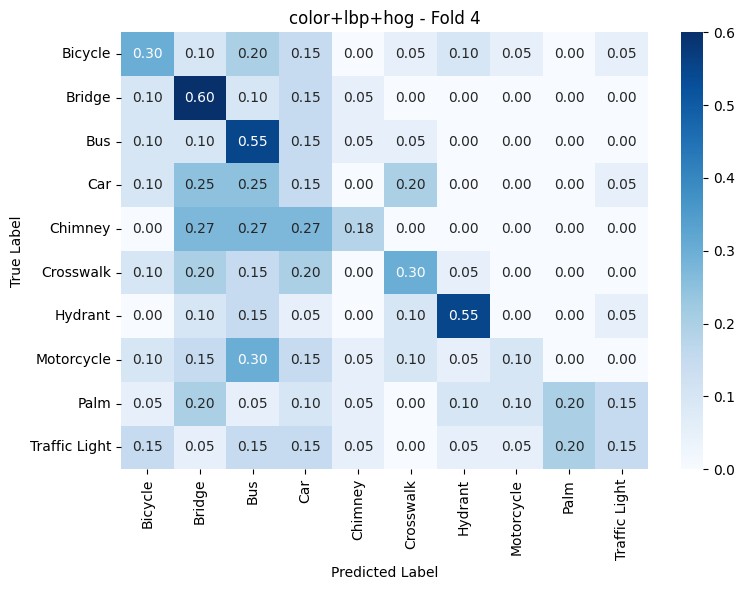


--- Ï°∞Ìï©: color+law+hog (Fold 4) ---
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+law+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+law+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3194 (Fold 4, Ï°∞Ìï© color+law+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3058 (Fold 4, Ï°∞Ìï© color+law+hog)


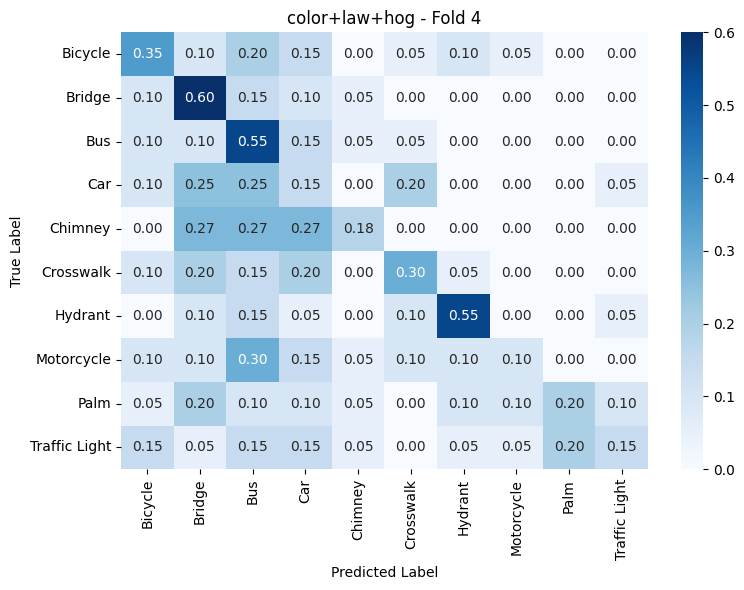


--- Ï°∞Ìï©: color+law+sift (Fold 4) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 4, Ï°∞Ìï© color+law+sift)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+law+sift)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+law+sift)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.2880 (Fold 4, Ï°∞Ìï© color+law+sift)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.2882 (Fold 4, Ï°∞Ìï© color+law+sift)


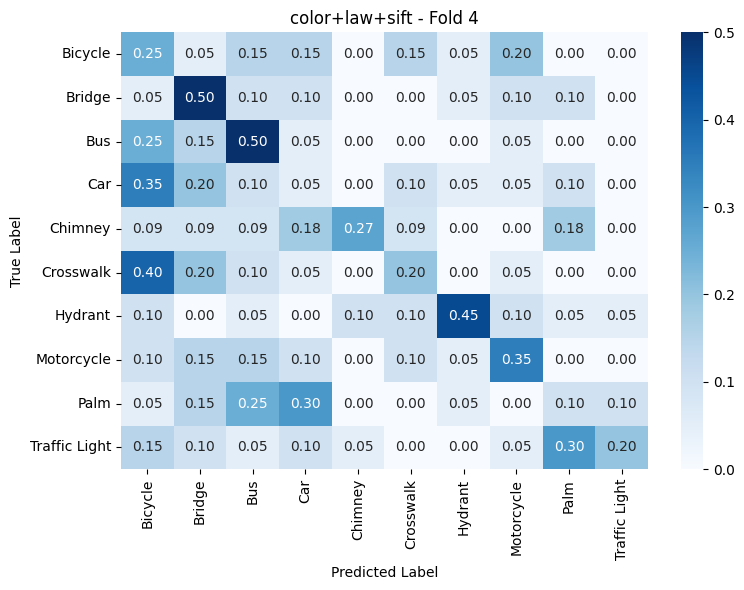


--- Ï°∞Ìï©: color+lbp+sift+hog (Fold 4) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 4, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+lbp+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3351 (Fold 4, Ï°∞Ìï© color+lbp+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3226 (Fold 4, Ï°∞Ìï© color+lbp+sift+hog)


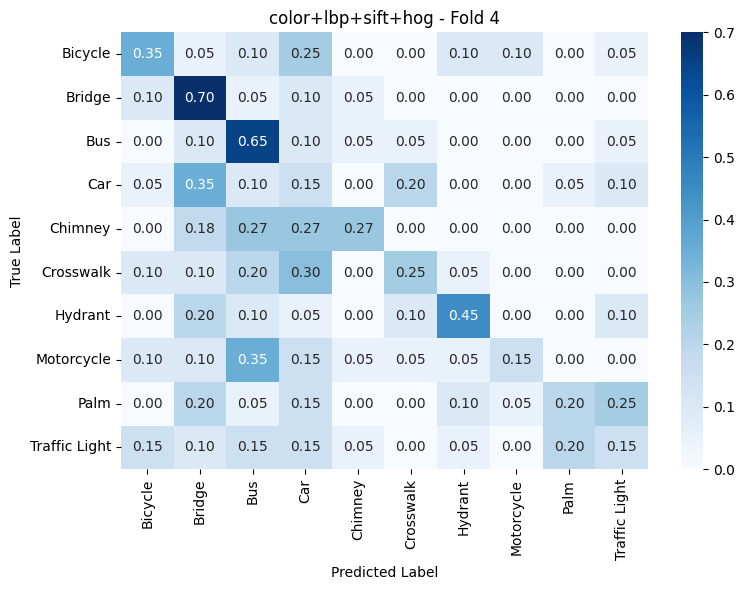


--- Ï°∞Ìï©: color+law+sift+hog (Fold 4) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 4, Ï°∞Ìï© color+law+sift+hog)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+law+sift+hog)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+law+sift+hog)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3351 (Fold 4, Ï°∞Ìï© color+law+sift+hog)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3247 (Fold 4, Ï°∞Ìï© color+law+sift+hog)


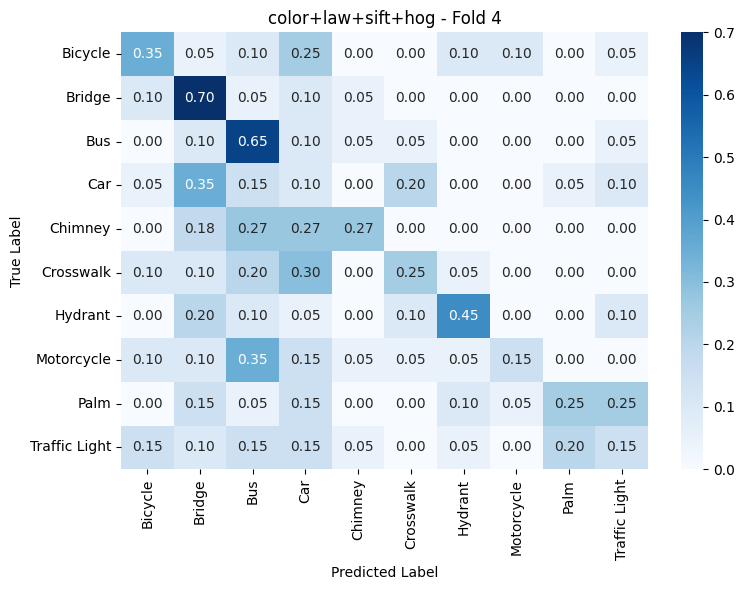


--- Ï°∞Ìï©: color+lbp+sift+hog+law (Fold 4) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 4, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold 4, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k=3, Fold 4, Ï°∞Ìï© color+lbp+sift+hog+law)...
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: 0.3351 (Fold 4, Ï°∞Ìï© color+lbp+sift+hog+law)
  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: 0.3226 (Fold 4, Ï°∞Ìï© color+lbp+sift+hog+law)


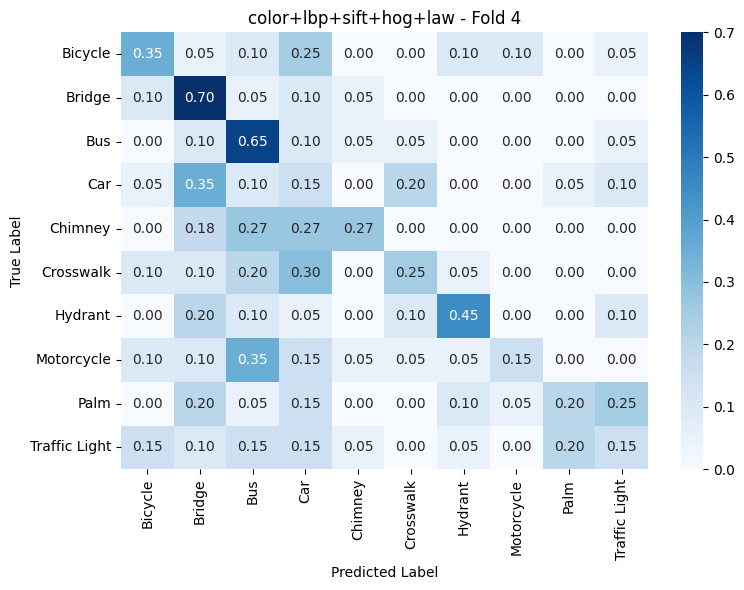


=============== FOLD 5/5 ================
  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold 5)

--- Ï°∞Ìï©: color+sift (Fold 5) ---
  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å (300 clusters).
  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold 5, Ï°∞Ìï© color+sift)...


KeyboardInterrupt: 

In [19]:
# ÏÇ¨Ïö©Ìï† ÌäπÏßï Ï°∞Ìï© Ï†ïÏùò
#feature_names = ['color', 'hog', 'lbp', 'sift']
all_feature_combinations_tuples = []
#from itertools import combinations
#for i in range(1, len(feature_names) + 1):
#    for combo in combinations(feature_names, i):
#        all_feature_combinations_tuples.append(combo)

# ÏÇ¨Ïö©ÏûêÍ∞Ä ÏöîÏ≤≠Ìïú ÌäπÏ†ï Ï°∞Ìï© Ï∂îÍ∞Ä (ÌïÑÏöîÏãú)
user_requested_combinations = [
 ('color', 'sift'), ('color', 'lbp'), ('color', 'lbp', 'hog'),
 ('color', 'law', 'hog'), ('color', 'law', 'sift'), 
 ('color', 'lbp', 'sift', 'hog'),('color', 'law', 'sift', 'hog'), ('color', 'lbp', 'sift', 'hog', 'law')
]
all_feature_combinations_tuples.extend(user_requested_combinations)
# # Ï§ëÎ≥µ Ï†úÍ±∞
# all_feature_combinations_tuples = sorted(list(set(all_feature_combinations_tuples)))


print(f"\n‚ñ∂ Ï¥ù {len(all_feature_combinations_tuples)}Í∞úÏùò ÌäπÏßï Ï°∞Ìï©Ïóê ÎåÄÌï¥ ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÏàòÌñâÌï©ÎãàÎã§.")
for combo in all_feature_combinations_tuples:
    print(f"  - {combo}")

# Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
results = {}
confusion_matrices = {}

X_indices = np.arange(len(images_df)) # StratifiedKFoldÏóê ÏÇ¨Ïö©Ìï† Ïù∏Îç±Ïä§
y_labels = images_df['label_encoded'].values

# Stratified K-Fold Ï§ÄÎπÑ
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # ÎÖ∏Ìä∏Î∂ÅÏùò Í∏∞Î≥∏ 5-fold ÏÇ¨Ïö©
print("\n‚úî Stratified K-Fold ÏÑ§Ï†ï ÏôÑÎ£å (5-Fold)")

# ÍµêÏ∞® Í≤ÄÏ¶ù Î£®ÌîÑ
num_bovw_clusters = 300 # BoVW ÌÅ¥Îü¨Ïä§ÌÑ∞ Ïàò (ÎÖ∏Ìä∏Î∂ÅÏùò get_features_for_split Ìï®Ïàò ÎÇ¥ num_bovw_clusters=200 Ï∞∏Í≥†, Ï§ÑÏó¨ÏÑú ÌÖåÏä§Ìä∏)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_indices, y_labels)):
    print(f"\n=============== FOLD {fold+1}/5 ================")
    y_train_fold, y_val_fold = y_labels[train_idx], y_labels[val_idx]
    # ÌòÑÏû¨ Ìè¥ÎìúÏùò SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞ (ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïö©, Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïö©)
    sift_descriptors_train_fold = [sift_descriptors_list_all[i] for i in train_idx]
    sift_descriptors_val_fold = [sift_descriptors_list_all[i] for i in val_idx]

    print(f"  ‚è≥ BoVW Vocabulary ÌïôÏäµ Ï§ë (Fold {fold+1})")
    # SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÌïòÎÇòÎèÑ ÏóÜÎäî Í≤ΩÏö∞Î•º Î∞©ÏßÄ
    valid_sift_descriptors_train_fold = [d for d in sift_descriptors_train_fold if d is not None and len(d) > 0]
    bovw_vocabulary = learn_bovw_vocabulary(valid_sift_descriptors_train_fold, num_clusters=num_bovw_clusters)


    # Í∞Å ÌäπÏßï Ï°∞Ìï©Ïóê ÎåÄÌï¥ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
    for feature_combo_tuple in all_feature_combinations_tuples:
        feature_combo_name = '+'.join(feature_combo_tuple)
        print(f"\n--- Ï°∞Ìï©: {feature_combo_name} (Fold {fold+1}) ---")
        
        X_train_features_list = []
        X_val_features_list = []
        
        if 'color' in feature_combo_tuple:
            X_train_features_list.append(features_color_all[train_idx])
            X_val_features_list.append(features_color_all[val_idx])
        if 'hog' in feature_combo_tuple:
            X_train_features_list.append(features_hog_all[train_idx])
            X_val_features_list.append(features_hog_all[val_idx])
        if 'lbp' in feature_combo_tuple:
            X_train_features_list.append(features_lbp_all[train_idx])
            X_val_features_list.append(features_lbp_all[val_idx])
        if 'laws' in feature_combo_tuple:
            X_train_features_list.append(features_laws_all[train_idx])
            X_val_features_list.append(features_laws_all[val_idx])    
        if 'sift' in feature_combo_tuple:
            if not valid_sift_descriptors_train_fold:
                print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: Fold {fold+1}Ïùò ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê Ïú†Ìö®Ìïú SIFT ÎîîÏä§ÌÅ¨Î¶ΩÌÑ∞Í∞Ä ÏóÜÏñ¥ BoVW ÌäπÏßïÏùÑ ÏÉùÏÑ±Ìï† Ïàò ÏóÜÏäµÎãàÎã§. Ïù¥ Ï°∞Ìï©/Ìè¥ÎìúÎäî Í±¥ÎÑàÎúÅÎãàÎã§.")
                # Îπà ÌûàÏä§ÌÜ†Í∑∏Îû® ÎòêÎäî Ïò§Î•ò Ï≤òÎ¶¨
                num_features_sift = num_bovw_clusters 
                train_bovw_hist = np.zeros((len(train_idx), num_features_sift))
                val_bovw_hist = np.zeros((len(val_idx), num_features_sift))
            else:
                if bovw_vocabulary is None or bovw_vocabulary.shape[0] == 0 :
                     print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: Fold {fold+1}ÏóêÏÑú BoVW vocabulary ÌïôÏäµÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. Ïù¥ Ï°∞Ìï©/Ìè¥ÎìúÎäî Í±¥ÎÑàÎúÅÎãàÎã§.")
                     num_features_sift = num_bovw_clusters 
                     train_bovw_hist = np.zeros((len(train_idx), num_features_sift))
                     val_bovw_hist = np.zeros((len(val_idx), num_features_sift))
                else:
                    print(f"  ‚úî BoVW Vocabulary ÌïôÏäµ ÏôÑÎ£å ({bovw_vocabulary.shape[0]} clusters).")
                    print(f"  ‚è≥ BoVW Histogram ÏÉùÏÑ± Ï§ë (Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})...")
                    train_bovw_hist = np.array([create_bovw_histogram(sift_descriptors_train_fold[i], bovw_vocabulary) for i in range(len(sift_descriptors_train_fold))])
                    val_bovw_hist = np.array([create_bovw_histogram(sift_descriptors_val_fold[i], bovw_vocabulary) for i in range(len(sift_descriptors_val_fold))])

            X_train_features_list.append(train_bovw_hist)
            X_val_features_list.append(val_bovw_hist)

        if not X_train_features_list: # ÌäπÏßïÏù¥ ÌïòÎÇòÎèÑ ÏÑ†ÌÉùÎêòÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ (ÏùºÏñ¥ÎÇ† Ïùº ÏóÜÏßÄÎßå Î∞©Ïñ¥ ÏΩîÎìú)
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: ÌäπÏßïÏù¥ ÏÑ†ÌÉùÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§ ({feature_combo_name}). Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue

        # ÌäπÏßï Í≤∞Ìï©
        X_train_combined = combine_features(*X_train_features_list)
        X_val_combined = combine_features(*X_val_features_list)
        
        # Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî (ÌïÑÏöîÏãú Ï∂îÍ∞Ä - Ïòà: StandardScaler ÎòêÎäî MinMaxScaler)
        # scaler = StandardScaler()
        # X_train_combined = scaler.fit_transform(X_train_combined)
        # X_val_combined = scaler.transform(X_val_combined)
        # print("  ‚ÑπÔ∏è ÌäπÏßï Ï†ïÍ∑úÌôî Ï†ÅÏö©Îê®.")

        print(f"  ‚è≥ Faiss KNN Î™®Îç∏ ÌïôÏäµ Ï§ë (k=3, Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})...")
        # NaN ÎòêÎäî Inf Í∞í ÌôïÏù∏ Î∞è Ï≤òÎ¶¨ (Ï§ëÏöî!)
        if np.isnan(X_train_combined).any() or np.isinf(X_train_combined).any():
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: X_train_combinedÏóê NaN ÎòêÎäî Inf Í∞íÏù¥ Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏäµÎãàÎã§. 0ÏúºÎ°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§. (Ï°∞Ìï©: {feature_combo_name}, Fold: {fold+1})")
            X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=0.0, neginf=0.0) # ÎòêÎäî Îã§Î•∏ ÎåÄÏ≤¥ Ï†ÑÎûµ
        if np.isnan(X_val_combined).any() or np.isinf(X_val_combined).any():
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: X_val_combinedÏóê NaN ÎòêÎäî Inf Í∞íÏù¥ Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏäµÎãàÎã§. 0ÏúºÎ°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§. (Ï°∞Ìï©: {feature_combo_name}, Fold: {fold+1})")
            X_val_combined = np.nan_to_num(X_val_combined, nan=0.0, posinf=0.0, neginf=0.0)

        # ÌäπÏßï Î≤°ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÍ±∞ÎÇò Î™®Îì† Í∞íÏù¥ 0Ïù∏ Í≤ΩÏö∞Î•º Ï≤òÎ¶¨ (L2 Ï†ïÍ∑úÌôî Îì±ÏóêÏÑú Î¨∏Ï†ú Î∞úÏÉù Í∞ÄÎä•)
        if X_train_combined.shape[1] == 0:
            print(f"  ‚ö†Ô∏è Í≤ΩÍ≥†: ÌõàÎ†® ÌäπÏßï Î≤°ÌÑ∞Í∞Ä ÎπÑÏñ¥ÏûàÏäµÎãàÎã§. (Ï°∞Ìï©: {feature_combo_name}, Fold: {fold+1}). Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue
        
        # FaissÎäî float32 ÌÉÄÏûÖÏùÑ ÏöîÍµ¨Ìï®
        X_train_combined = X_train_combined.astype(np.float32)
        X_val_combined = X_val_combined.astype(np.float32)

        try:
            faiss_index, train_labels_for_pred, n_neighbors_actual = train_faiss_knn_euclidean(X_train_combined, y_train_fold, n_neighbors=3)
            
            print(f"  ‚ñ∂ KNN ÏòàÏ∏° Ï§ë (Faiss ÏÇ¨Ïö©, k={n_neighbors_actual}, Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})...")
            y_pred_fold = predict_faiss_knn_euclidean(faiss_index, train_labels_for_pred, n_neighbors_actual, X_val_combined)
            
            acc = accuracy_score(y_val_fold, y_pred_fold)
            fsc = f1_score(y_val_fold,y_pred_fold, average= 'weighted')
            print(f"  ‚úî ÏòàÏ∏° ÏôÑÎ£å. Accuracy: {acc:.4f} (Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})")
            print(f"  ‚úî ÏòàÏ∏° ÏôÑÎ£å. F1-Score: {fsc:.4f} (Fold {fold+1}, Ï°∞Ìï© {feature_combo_name})")
            
            cm = confusion_matrix(y_val_fold, y_pred_fold)
            if feature_combo_name not in confusion_matrices:
                confusion_matrices[feature_combo_name] = {}
            confusion_matrices[feature_combo_name][fold] = cm
            
            if feature_combo_name not in results:
                results[feature_combo_name] = []
            results[feature_combo_name].append(acc)
            # Confusion Matrix ÏãúÍ∞ÅÌôî
            plot_confusion_matrix(
                cm,
                class_names=['Bicycle','Bridge','Bus', 'Car', 'Chimney','Crosswalk','Hydrant','Motorcycle','Palm','Traffic Light'],
                title=f'{feature_combo_name} - Fold {fold+1}',
                normalize=True
            )
        except Exception as e:
            print(f"  ‚ùå Ïò§Î•ò Î∞úÏÉù (Î™®Îç∏ ÌïôÏäµ/ÏòàÏ∏° Ï§ë, Fold {fold+1}, Ï°∞Ìï© {feature_combo_name}): {e}")
            if feature_combo_name not in results: # Ïò§Î•ò Î∞úÏÉù ÏãúÏóêÎèÑ ÌÇ§Îäî ÎßåÎì§Ïñ¥ Îë†
                results[feature_combo_name] = []
            results[feature_combo_name].append(np.nan) # Ïò§Î•ò Î∞úÏÉù Ïãú NaNÏúºÎ°ú Í∏∞Î°ù


# ÏµúÏ¢Ö Í≤∞Í≥º ÏßëÍ≥Ñ Î∞è Ï∂úÎ†•
print("\n\n=============== ÏµúÏ¢Ö ÍµêÏ∞® Í≤ÄÏ¶ù Í≤∞Í≥º ================")
for combo_name, acc_list in results.items():
    valid_acc_list = [acc for acc in acc_list if not np.isnan(acc)]
    if valid_acc_list:
        mean_acc = np.mean(valid_acc_list)
        std_acc = np.std(valid_acc_list)
        print(f"ÌäπÏßï Ï°∞Ìï©: {combo_name}")
        for i, acc_fold in enumerate(acc_list):
             print(f"  Fold {i+1} Accuracy: {acc_fold:.4f}" if not np.isnan(acc_fold) else f"  Fold {i+1} Accuracy: Error")
        print(f"  >> ÌèâÍ∑† Ï†ïÌôïÎèÑ: {mean_acc:.4f} (ÌëúÏ§ÄÌé∏Ï∞®: {std_acc:.4f})")
    else:
        print(f"ÌäπÏßï Ï°∞Ìï©: {combo_name} - Î™®Îì† Ìè¥ÎìúÏóêÏÑú Ïò§Î•ò Î∞úÏÉù ÎòêÎäî Ïú†Ìö®Ìïú Í≤∞Í≥º ÏóÜÏùå.")
    print("-" * 30)

# Í∞ÄÏû• ÏÑ±Îä•Ïù¥ Ï¢ãÏùÄ Ï°∞Ìï© Ï∞æÍ∏∞ (ÌèâÍ∑† Ï†ïÌôïÎèÑ Í∏∞Ï§Ä)
if results:
    sorted_results = sorted(results.items(), key=lambda item: np.nanmean(item[1]) if item[1] else -1, reverse=True)
    print("\nüèÜ ÏµúÍ≥† ÏÑ±Îä• Ï°∞Ìï© (ÌèâÍ∑† Ï†ïÌôïÎèÑ Í∏∞Ï§Ä):")
    if sorted_results and np.nanmean(sorted_results[0][1]):
         best_combo_name, best_acc_list = sorted_results[0]
         print(f"  {best_combo_name}: ÌèâÍ∑† Ï†ïÌôïÎèÑ = {np.nanmean(best_acc_list):.4f}")
    else:
        print("  Ïú†Ìö®Ìïú Í≤∞Í≥ºÎ•º Í∞ÄÏßÑ Ï°∞Ìï©Ïù¥ ÏóÜÏäµÎãàÎã§.")